In [ ]:
#  библиотеки
!pip install torchaudio
!pip install pytorch-lightning
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import os
from torchmetrics.classification import Accuracy

class SubsetSC(Dataset):
    def __init__(self, subset):
        self.subset = subset
        self.yes_no_mapping = {"yes": 1, "no": 0}

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        waveform, sample_rate, label, *_ = self.subset[idx]
        label = self.yes_no_mapping[label]
        return waveform, label

def filter_data(subset):
    yes_no_classes = ["yes", "no"]
    filtered_data = [item for item in subset if item[2] in yes_no_classes]
    return SubsetSC(filtered_data)



In [ ]:
import os
import torchaudio


DATA_DIR = "./data"
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Загрузка данных Google Speech Commands
train_data = torchaudio.datasets.SPEECHCOMMANDS(root=DATA_DIR, download=True, subset="training")
val_data = torchaudio.datasets.SPEECHCOMMANDS(root=DATA_DIR, download=True, subset="validation")
test_data = torchaudio.datasets.SPEECHCOMMANDS(root=DATA_DIR, download=True, subset="testing")

100%|██████████| 2.26G/2.26G [00:23<00:00, 104MB/s]


In [ ]:
# Фильтрация классов "YES" и "NO"
train_data = filter_data(train_data)
val_data = filter_data(val_data)
test_data = filter_data(test_data)

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    #  максимальную длину в батче
    max_len = max([audio.shape[1] for audio, _ in batch])

    # Заполнение все аудиофайлы до максимальной длины
    audio_padded = [torch.nn.functional.pad(audio, (0, max_len - audio.shape[1])) for audio, _ in batch]

    #  тензоры
    audio_padded = torch.stack(audio_padded)
    labels = torch.tensor([label for _, label in batch])

    return audio_padded, labels

# загрузки данных с использованием collate_fn
train_loader = DataLoader(train_data, batch_size=32, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=collate_fn)


In [ ]:
import torch
import torch.nn as nn

import torch.nn.functional as F

from torchmetrics import Accuracy

class CNNModel(nn.Module):
    def __init__(self, n_mels=80):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_mels, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(self._get_flattened_size(n_mels), 128)
        self.fc2 = nn.Linear(128, 2)

    def conv_forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        return x

    def _get_flattened_size(self, n_mels,seq_len=101):
        with torch.no_grad():
            x = torch.zeros(1, n_mels, seq_len)  # разные n_mels
            x = self.conv_forward(x)
            x = x.view(1, -1)
        return x.size(1)


    def forward(self, x):
        x = self.conv_forward(x)
        x = x.view(x.size(0), -1)
        print(f"Shape after flatten: {x.shape}")
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
from collections import Counter
label_counts = Counter([label for _, label in train_data])
print(label_counts)  # Проверка распределения классов


Counter({1: 3228, 0: 3130})


In [ ]:
from typing import Optional
import torch
from torch import nn
import torchaudio.functional as AF  # AF для аудиофункций
import pytorch_lightning as pl

class LogMelFilterBanks(nn.Module):
    def __init__(
            self,
            n_fft: int = 400,
            samplerate: int = 16000,
            hop_length: int = 160,
            n_mels: int = 80,
            pad_mode: str = 'reflect',
            power: float = 2.0,
            normalize_stft: bool = False,
            onesided: bool = True,
            center: bool = True,
            return_complex: bool = True,
            f_min_hz: float = 0.0,
            f_max_hz: Optional[float] = None,
            norm_mel: Optional[str] = None,
            mel_scale: str = 'htk'
        ):
        super(LogMelFilterBanks, self).__init__()
        # General parameters
        self.n_fft = n_fft
        self.samplerate = samplerate
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.f_min_hz = f_min_hz
        self.f_max_hz = f_max_hz if f_max_hz is not None else samplerate / 2
        self.norm_mel = norm_mel
        self.mel_scale = mel_scale
        self.window = torch.hann_window(n_fft)

        # Initialize mel filter banks
        self.mel_fbanks = self._init_melscale_fbanks()

    def _init_melscale_fbanks(self):
        n_freqs = self.n_fft // 2 + 1  # Количество частотных бинов
        return AF.melscale_fbanks(
            n_freqs=n_freqs,
            f_min=self.f_min_hz,
            f_max=self.f_max_hz,
            n_mels=self.n_mels,
            sample_rate=self.samplerate,
            norm=self.norm_mel,
            mel_scale=self.mel_scale
        )

    def spectrogram(self, x):
      if x.dim() == 3 and x.shape[1] == 1:
        x = x.squeeze(1)  # Убираем лишний канал

      stft_result = torch.stft(
        x,
        n_fft=self.n_fft,
        hop_length=self.hop_length,
        win_length=self.n_fft,
        window=self.window.to(x.device),
        center=True,
        pad_mode='reflect',
        normalized=False,
        onesided=True,
        return_complex=True
      )

    # Power spectrum
      power_spec = stft_result.abs() ** 2
      return power_spec


    def forward(self, x):
    # Получение power spectrogram
      power_spec = self.spectrogram(x)

    # Применение фильтров mel scale
      mel_energies = torch.matmul(power_spec.transpose(1, 2), self.mel_fbanks)
      log_mel_spec = torch.log(mel_energies + 1e-6)  # Логарифм
      return log_mel_spec



In [ ]:
class AudioClassifier(pl.LightningModule):
    def __init__(self, logmel_filterbanks, model):
        super(AudioClassifier, self).__init__()
        self.logmel_filterbanks = logmel_filterbanks
        self.model = model
        self.accuracy = Accuracy(task="multiclass", num_classes=2)


    def forward(self, x):
        print(f"Input waveform shape: {x.shape}")  # (batch_size, 1, waveform_length)
        # Преобразование в Log-Mel спектр
        logmel_spec = self.logmel_filterbanks(x)
        print(f"Log-Mel shape before transpose: {logmel_spec.shape}")  # (batch_size, n_mels, n_frames)
        logmel_spec = logmel_spec.transpose(1, 2)  # Приводим к (batch, n_mels, n_frames)
        print(f"Log-Mel shape after transpose: {logmel_spec.shape}")  # (batch_size, n_frames, n_mels)


        #return self.model(logmel_spec)
        output = self.model(logmel_spec)
        print(f"CNN output shape: {output.shape}")  # (batch_size, num_classes)

        return output

    def training_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)  # logits размерности [32, 2]
      loss = F.cross_entropy(logits, y)  # y должен быть [32] с индексами классов
      self.log("train_loss", loss)
      return loss

    def validation_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = F.cross_entropy(logits, y)

      # Извлечение вероятностей и предсказаний для Accuracy
      preds = torch.argmax(logits, dim=1)  # [32] с индексами классов
      acc = self.accuracy(preds, y)  # Сравнение предсказанных и реальных меток

      self.log("val_loss", loss)
      self.log("val_acc", acc)
      return loss

    def test_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = F.cross_entropy(logits, y)

    #  logits в вероятности  предсказания
      preds = torch.argmax(logits, dim=1)  # [32] с индексами классов
      acc = self.accuracy(preds, y)

      self.log("test_loss", loss, prog_bar=True)
      self.log("test_acc", acc, prog_bar=True)
      return loss



    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [ ]:
for batch in test_loader:
    x, y = batch
    print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")
    break


Shape of x: torch.Size([32, 1, 16000]), Shape of y: torch.Size([32])


In [ ]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
results = []
n_mels_list = [20, 40, 80]

for n_mels in n_mels_list:
    print(f"Training with n_mels = {n_mels}")

    # Инициализация LogMelFilterBanks
    logmel_filterbanks = LogMelFilterBanks(
        samplerate=16000,
        hop_length=160,
        n_mels=n_mels
    )

    cnn_model = CNNModel(n_mels=n_mels)
    model = AudioClassifier(logmel_filterbanks, cnn_model)

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="cpu",
        devices=1
    )

    trainer.fit(model, train_loader, val_loader)
    test_results = trainer.test(model, test_loader)[0]  # Получаем результаты теста

    #  результаты для  n_mels
    results.append({
        "n_mels": n_mels,
        "test_loss": test_results["test_loss"],
        "test_acc": test_results["test_acc"]
    })


for res in results:
    print(f"n_mels={res['n_mels']}, Test Accuracy: {res['test_acc']:.4f}, Test Loss: {res['test_loss']:.4f}")


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | logmel_filterbanks | LogMelFilterBanks  | 0      | train
1 | model              | CNNModel           | 925 K  | train
2 | accuracy           | MulticlassAccuracy | 0      | train
------------------------------------------------------------------
925 K     Trainable params
0         Non-trainable params
925 K     Total params
3.704     Total estimated model params size (MB)
7         Modules in train m

Training with n_mels = 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])


Training: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([3, 1, 16000])
Log-Mel shape before transpose: torch.Size([3, 101, 20])
Log-Mel shape after transpose: torch.Size([3, 20, 101])
Shape after flatten: torch.Size([3, 6400])
CNN output shape: torch.Size([3, 2])


Testing: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5084951519966125     │
│         test_loss         │     45.97570037841797     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Training with n_mels = 40


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | logmel_filterbanks | LogMelFilterBanks  | 0      | train
1 | model              | CNNModel           | 933 K  | train
2 | accuracy           | MulticlassAccuracy | 0      | train
------------------------------------------------------------------
933 K     Trainable params
0         Non-trainable params
933 K     Total params
3.735     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])


Training: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([3, 1, 16000])
Log-Mel shape before transpose: torch.Size([3, 101, 40])
Log-Mel shape after transpose: torch.Size([3, 40, 101])
Shape after flatten: torch.Size([3, 6400])
CNN output shape: torch.Size([3, 2])


Testing: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5084951519966125     │
│         test_loss         │    0.7023597359657288     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Training with n_mels = 80


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | logmel_filterbanks | LogMelFilterBanks  | 0      | train
1 | model              | CNNModel           | 948 K  | train
2 | accuracy           | MulticlassAccuracy | 0      | train
------------------------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.796     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])


Training: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5084951519966125     │
│         test_loss         │    0.6990795731544495     │
└───────────────────────────┴───────────────────────────┘

n_mels=20, Test Accuracy: 0.5085, Test Loss: 45.9757
n_mels=40, Test Accuracy: 0.5085, Test Loss: 0.7024
n_mels=80, Test Accuracy: 0.5085, Test Loss: 0.6991


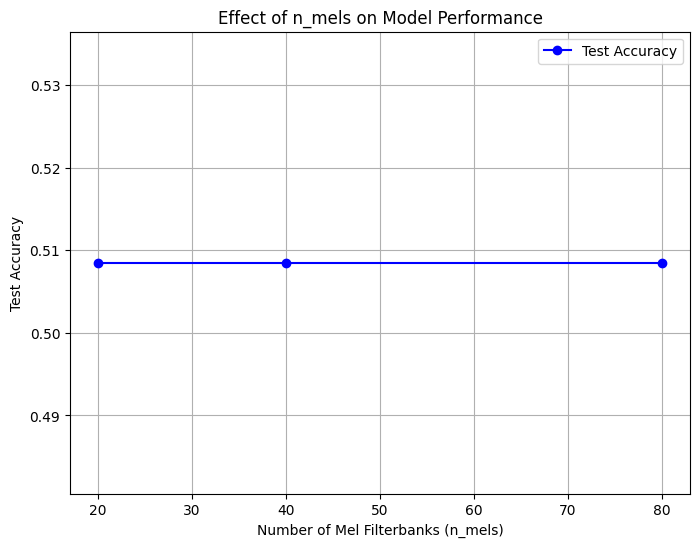

In [ ]:
import matplotlib.pyplot as plt

#  значения n_mels и test_acc
n_mels_vals = [res['n_mels'] for res in results]
acc_vals = [res['test_acc'] for res in results]
loss_vals = [res['test_loss'] for res in results]

# Построение графика для Test Accuracy
plt.figure(figsize=(8, 6))
plt.plot(n_mels_vals, acc_vals, marker='o', linestyle='-', color='b', label="Test Accuracy")
plt.xlabel("Number of Mel Filterbanks (n_mels)")
plt.ylabel("Test Accuracy")
plt.title("Effect of n_mels on Model Performance")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
#Попытка 3.
from pytorch_lightning.callbacks import EarlyStopping

# Инициализация Early Stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min"  # Останов при мин val_loss
)

results = []
n_mels_list = [20, 40, 80]

for n_mels in n_mels_list:
    print(f"Training with n_mels = {n_mels}")

    # Инициализация LogMelFilterBanks
    logmel_filterbanks = LogMelFilterBanks(
        samplerate=16000,
        hop_length=160,
        n_mels=n_mels
    )

    # Инициализация CNN модели и AudioClassifier
    cnn_model = CNNModel(n_mels=n_mels)
    model = AudioClassifier(logmel_filterbanks, cnn_model)

    #  Trainer для каждого n_mels
    trainer = pl.Trainer(
        max_epochs=30,
        accelerator="cpu",
        devices=1,
        callbacks=[early_stop_callback]
    )

    # Обучение модели
    trainer.fit(model, train_loader, val_loader)

    # Тестовая выборка
    test_results = trainer.test(model, test_loader)[0]

    #  результаты для текущего n_mels
    results.append({
        "n_mels": n_mels,
        "test_loss": test_results["test_loss"],
        "test_acc": test_results["test_acc"]
    })

# результаты
for res in results:
    print(f"n_mels={res['n_mels']}, Test Accuracy: {res['test_acc']:.4f}, Test Loss: {res['test_loss']:.4f}")


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | logmel_filterbanks | LogMelFilterBanks  | 0      | train
1 | model              | CNNModel           | 925 K  | train
2 | accuracy           | MulticlassAccuracy | 0      | train
------------------------------------------------------------------
925 K     Trainable params
0         Non-trainable params
925 K     Total params
3.704     Total estimated model params size (MB)
7         Modules in train m

Training with n_mels = 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])


Training: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Testing: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5084951519966125     │
│         test_loss         │    29.304439544677734     │
└───────────────────────────┴───────────────────────────┘

Training with n_mels = 40


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | logmel_filterbanks | LogMelFilterBanks  | 0      | train
1 | model              | CNNModel           | 933 K  | train
2 | accuracy           | MulticlassAccuracy | 0      | train
------------------------------------------------------------------
933 K     Trainable params
0         Non-trainable params
933 K     Total params
3.735     Total estimated model params size (MB)
7         Modules in train m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])


Training: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Testing: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 40])
Log-Mel shape after transpose: torch.Size([32, 40, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5084951519966125     │
│         test_loss         │    51.764896392822266     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | logmel_filterbanks | LogMelFilterBanks  | 0      | train
1 | model              | CNNModel           | 948 K  | train
2 | accuracy           | MulticlassAccuracy | 0      | train
------------------------------------------------------------------
948 K     Trainable params
0         Non-trainable params
948 K     Total params
3.796     Total estimated model params size (MB)
7         Modules in train m

Training with n_mels = 80


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])


Training: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

Testing: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 80])
Log-Mel shape after transpose: torch.Size([32, 80, 101])
Shape after flatten: torch.Size([32, 6400])
CNN output shape: torch.Size([32, 2])
Input waveform s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5084951519966125     │
│         test_loss         │     76.75737762451172     │
└───────────────────────────┴───────────────────────────┘

n_mels=20, Test Accuracy: 0.5085, Test Loss: 29.3044
n_mels=40, Test Accuracy: 0.5085, Test Loss: 51.7649
n_mels=80, Test Accuracy: 0.5085, Test Loss: 76.7574


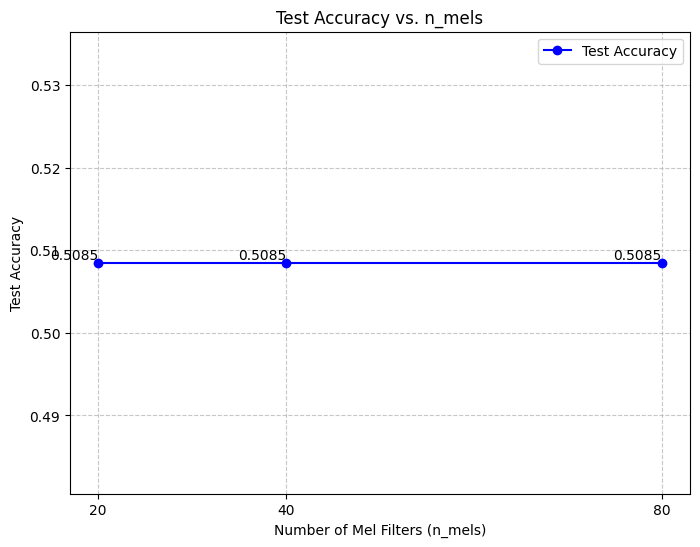

In [ ]:
import matplotlib.pyplot as plt


n_mels_values = [res["n_mels"] for res in results]
test_acc_values = [res["test_acc"] for res in results]

plt.figure(figsize=(8, 6))
plt.plot(n_mels_values, test_acc_values, marker='o', linestyle='-', color='b', label="Test Accuracy")

#  подписи
plt.title("Test Accuracy vs. n_mels")
plt.xlabel("Number of Mel Filters (n_mels)")
plt.ylabel("Test Accuracy")
plt.xticks(n_mels_values)
plt.grid(True, linestyle="--", alpha=0.7)

# метки на точки
for i, acc in enumerate(test_acc_values):
    plt.text(n_mels_values[i], acc, f"{acc:.4f}", ha="right", va="bottom")


plt.legend()
plt.show()


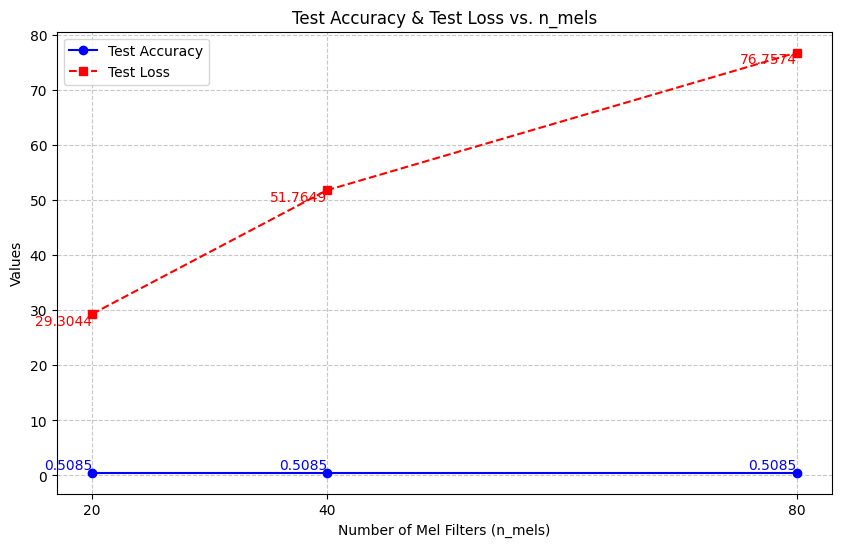

In [ ]:
import matplotlib.pyplot as plt


n_mels_values = [res["n_mels"] for res in results]
test_acc_values = [res["test_acc"] for res in results]
test_loss_values = [res["test_loss"] for res in results]


plt.figure(figsize=(10, 6))

# График для test_acc
plt.plot(n_mels_values, test_acc_values, marker='o', linestyle='-', color='b', label="Test Accuracy")

# График для test_loss
plt.plot(n_mels_values, test_loss_values, marker='s', linestyle='--', color='r', label="Test Loss")

# подписи точек
for i, (acc, loss) in enumerate(zip(test_acc_values, test_loss_values)):
    plt.text(n_mels_values[i], acc, f"{acc:.4f}", ha="right", va="bottom", color="blue")
    plt.text(n_mels_values[i], loss, f"{loss:.4f}", ha="right", va="top", color="red")


plt.title("Test Accuracy & Test Loss vs. n_mels")
plt.xlabel("Number of Mel Filters (n_mels)")
plt.ylabel("Values")
plt.xticks(n_mels_values)
plt.grid(True, linestyle="--", alpha=0.7)


plt.legend()

# Отображение графика
plt.show()


In [ ]:
# Вариант с groups n_mels=20
class CNNModel(nn.Module):
    def __init__(self, n_mels=20, groups=1):  #  Добавляем groups
        super(CNNModel, self).__init__()
        self.groups = groups

        self.conv1 = nn.Conv1d(
            in_channels=n_mels,
            out_channels=128,
            kernel_size=3,
            padding=1,
            groups=groups
        )

        self.conv2 = nn.Conv1d(
            in_channels=128,
            out_channels=256,
            kernel_size=3,
            padding=1,
            groups=groups
        )

        self.fc1 = nn.Linear(self._get_flattened_size(n_mels), 128)
        self.fc2 = nn.Linear(128, 2)

    def conv_forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        return x

    def _get_flattened_size(self, n_mels):
        with torch.no_grad():
            x = torch.zeros(1, n_mels, 101)
            x = self.conv_forward(x)
            x = x.view(1, -1)
        return x.size(1)

    def forward(self, x):
        x = self.conv_forward(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
!pip install torchinfo


In [30]:

from torchinfo import summary
from ptflops import get_model_complexity_info
import time

results = []

groups_list = [1, 2, 4]
n_mels = 20  # параметр
for groups in groups_list:
    print(f"Training with groups = {groups}")

    logmel_filterbanks = LogMelFilterBanks(
        samplerate=16000,
        hop_length=160,
        n_mels=n_mels
    )

    cnn_model = CNNModel(n_mels=n_mels, groups=groups)
    model = AudioClassifier(logmel_filterbanks, cnn_model)

    trainer = pl.Trainer(
        max_epochs=10,
        accelerator="cpu",
        devices=1
    )

    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    epoch_time = (time.time() - start_time) / 10  # Время на одну эпоху

    test_results = trainer.test(model, test_loader)[0]

    # Подсчёт параметров
    summary(cnn_model, input_size=(32, 20, 101))

    # Подсчёт FLOPs
    macs, params = get_model_complexity_info(
        cnn_model,
        (20, 101),  # (n_mels, длина аудиосигнала)
        as_strings=False,
        print_per_layer_stat=False,
        verbose=False
    )


    results.append({
        "groups": groups,
        "test_loss": test_results["test_loss"],
        "test_acc": test_results["test_acc"],
        "epoch_time": epoch_time,
        "num_params": params,
        "flops": macs
    })

# Вывод
for res in results:
    print(f"groups={res['groups']}, Test Accuracy: {res['test_acc']:.4f}, Test Loss: {res['test_loss']:.4f}, "
          f"Epoch Time: {res['epoch_time']:.4f}s, Params: {res['num_params']}, FLOPs: {res['flops']}")


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | logmel_filterbanks | LogMelFilterBanks  | 0      | train
1 | model              | CNNModel           | 925 K  | train
2 | accuracy           | MulticlassAccuracy | 0      | train
------------------------------------------------------------------
925 K     Trainable params
0         Non-trainable params
925 K     Total params
3.704     Total estimated model params size (MB)
7         Modules in train m

Training with groups = 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])


Training: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5084951519966125     │
│         test_loss         │    0.6930033564567566     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | logmel_filterbanks | LogMelFilterBanks  | 0      | train
1 | model              | CNNModel           | 872 K  | train
2 | accuracy           | MulticlassAccuracy | 0      | train
------------------------------------------------------------------
872 K     Trainable params
0         Non-trainable params
872 K     Total params
3.492     Total estimated model params size (MB)
7         Modules in train m

Training with groups = 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])


Training: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5084951519966125     │
│         test_loss         │    18.153736114501953     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Training with groups = 4


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type               | Params | Mode 
------------------------------------------------------------------
0 | logmel_filterbanks | LogMelFilterBanks  | 0      | train
1 | model              | CNNModel           | 846 K  | train
2 | accuracy           | MulticlassAccuracy | 0      | train
------------------------------------------------------------------
846 K     Trainable params
0         Non-trainable params
846 K     Total params
3.386     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])


Training: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

Validation: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([3, 1, 16000])
Log-Mel shape before transpose: torch.Size([3, 101, 20])
Log-Mel shape after transpose: torch.Size([3, 20, 101])
CNN output shape: torch.Size([3, 2])


Testing: |          | 0/? [00:00<?, ?it/s]

Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size([32, 2])
Input waveform shape: torch.Size([32, 1, 16000])
Log-Mel shape before transpose: torch.Size([32, 101, 20])
Log-Mel shape after transpose: torch.Size([32, 20, 101])
CNN output shape: torch.Size

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5084951519966125     │
│         test_loss         │    13.778306007385254     │
└───────────────────────────┴───────────────────────────┘

groups=1, Test Accuracy: 0.5085, Test Loss: 0.6930, Epoch Time: 22.2896s, Params: 925954, FLOPs: 6587778
groups=2, Test Accuracy: 0.5085, Test Loss: 18.1537, Epoch Time: 21.9896s, Params: 872962, FLOPs: 3742338
groups=4, Test Accuracy: 0.5085, Test Loss: 13.7783, Epoch Time: 21.7195s, Params: 846466, FLOPs: 2319618


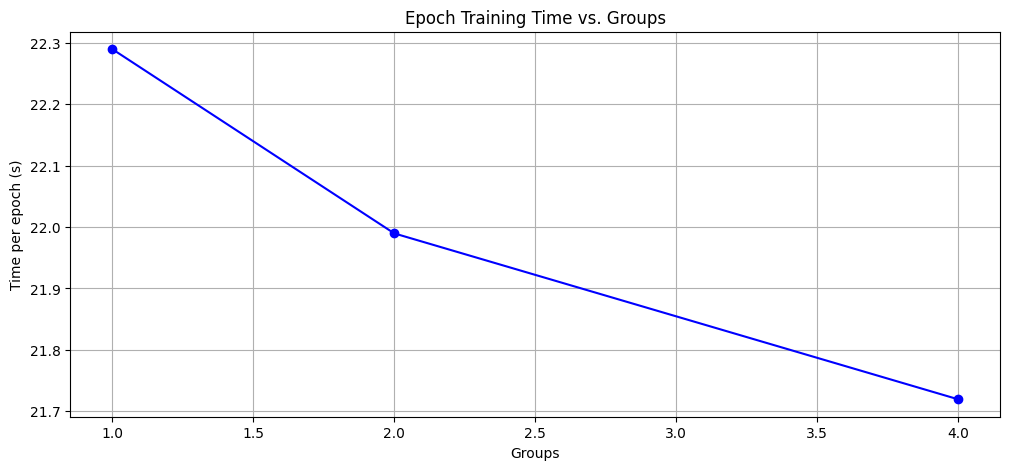

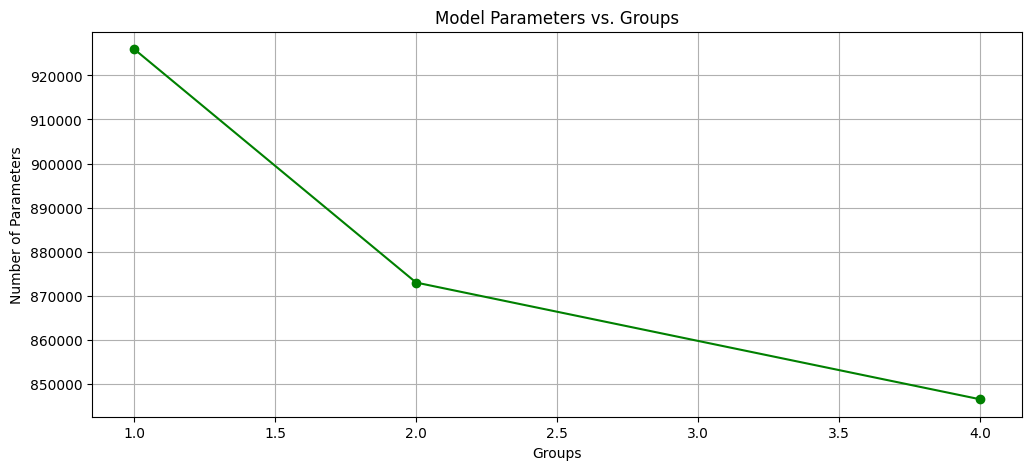

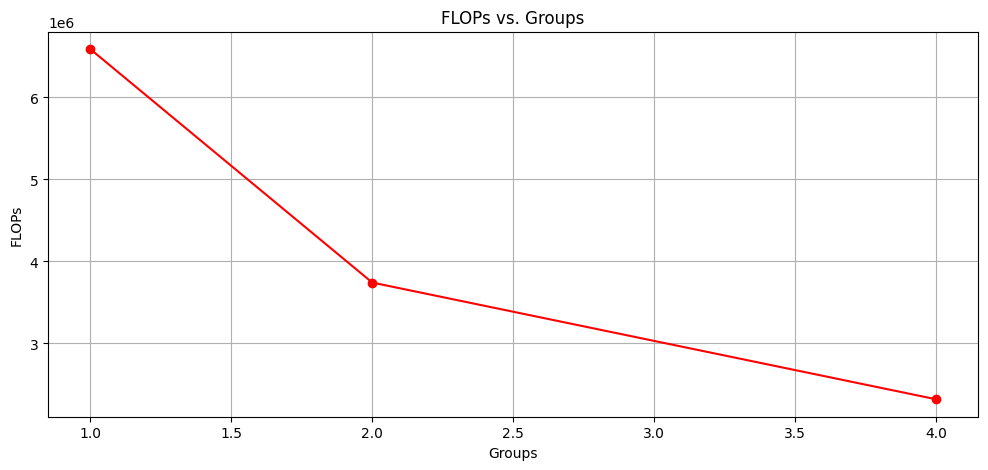

In [31]:
import matplotlib.pyplot as plt

groups = [res["groups"] for res in results]
epoch_times = [res["epoch_time"] for res in results]
params = [res["num_params"] for res in results]
flops = [res["flops"] for res in results]

# График времени от groups
plt.figure(figsize=(12, 5))
plt.plot(groups, epoch_times, 'o-', label="Epoch Time (s)", color="blue")
plt.xlabel("Groups")
plt.ylabel("Time per epoch (s)")
plt.title("Epoch Training Time vs. Groups")
plt.grid(True)
plt.show()

# График параметров от groups
plt.figure(figsize=(12, 5))
plt.plot(groups, params, 'o-', label="Number of Parameters", color="green")
plt.xlabel("Groups")
plt.ylabel("Number of Parameters")
plt.title("Model Parameters vs. Groups")
plt.grid(True)
plt.show()

# График FLOPs от groups
plt.figure(figsize=(12, 5))
plt.plot(groups, flops, 'o-', label="FLOPs", color="red")
plt.xlabel("Groups")
plt.ylabel("FLOPs")
plt.title("FLOPs vs. Groups")
plt.grid(True)
plt.show()


In [ ]:
#trainer.test(model, test_loader)

In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_params(model)
print(f"Количество параметров модели: {num_params}")


Количество параметров модели: 948994
